In [44]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from xbbg import blp



df = pd.read_csv("cnh18may25may.csv")
df.head()

,Underlying,Type,Strike,Expiry,Notional,Curr,Premium,Curr.1,Style,Code,Clr,Trd Time
0,USD CNY Vanilla Option,P,6.7145,06/23/22,"10,000,000.00",USD,"79,500.00",USD,EU,TR,U,05/25/2022 11:49:06
1,USD CNY Vanilla Option,C,6.7145,06/23/22,"10,000,000.00",USD,"81,250.00",USD,EU,TR,U,05/25/2022 11:49:06
2,USD CNY Vanilla Option,C,6.9250,07/15/22,"150,000,000.00",USD,"343,200.00",USD,EU,TR,U,05/25/2022 11:39:17
3,USD CNY Vanilla Option,C,6.8500,07/15/22,"150,000,000.00",USD,"573,450.00",USD,EU,TR,U,05/25/2022 11:39:16
4,USD CNY Vanilla Option,P,6.7100,06/23/22,"15,000,000.00",USD,"118,875.00",USD,EU,TR,U,05/25/2022 11:19:05


In [45]:
val=df.dropna()

val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 0 to 1249
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Underlying  1250 non-null   object 
 1   Type        1250 non-null   object 
 2   Strike      1250 non-null   float64
 3   Expiry      1250 non-null   object 
 4   Notional    1250 non-null   object 
 5   Curr        1250 non-null   object 
 6   Premium     1250 non-null   object 
 7   Curr.1      1250 non-null   object 
 8   Style       1250 non-null   object 
 9   Code        1250 non-null   object 
 10  Clr         1250 non-null   object 
 11  Trd Time    1250 non-null   object 
dtypes: float64(1), object(11)
memory usage: 127.0+ KB


In [46]:

def ccy_pair(in_str):
    ccy_pair = in_str[0:3]+in_str[4:7]
    return ccy_pair



In [47]:
val["CCY_PAIR"] = df['Underlying'].apply(lambda pair: ccy_pair(pair))
#val["Trd Time"]=val["Trd Time"].apply(lambda x:x[0:10])
#print(val["Trd Time"])
val["Trd Time"]=val["Trd Time"].apply(lambda x:datetime.strptime(x, '%m/%d/%Y %H:%M:%S').date())
val["Expiry"]=val["Expiry"].apply(lambda x:datetime.strptime(x,'%m/%d/%y'))
#val["Strike"]=val["Strike"].apply(lambda x:x.replace(",",""))
val["Strike"]=val["Strike"].apply(lambda x:float(x))
val["Notional"]=val["Notional"].apply(lambda x:x.replace(",",""))
val["Notional"]=val["Notional"].apply(lambda x: float(x))
val["Weekday"]=val["Trd Time"].apply(lambda x: x.weekday())


In [48]:
val = val.drop(val[val["Weekday"]==6].index)
val = val.drop(val[val["Weekday"]==5].index)
val = val.drop(val[val["Strike"]==0].index)

In [55]:
ccys=["EURUSD", "USDJPY", "GBPUSD", "USDCAD", "AUDUSD", "EURNOK", "EURCHF", "USDMXN", "USDCNY", "EURSEK", "USDNOK", "USDSEK"]
ccys2=["USDCNY"]

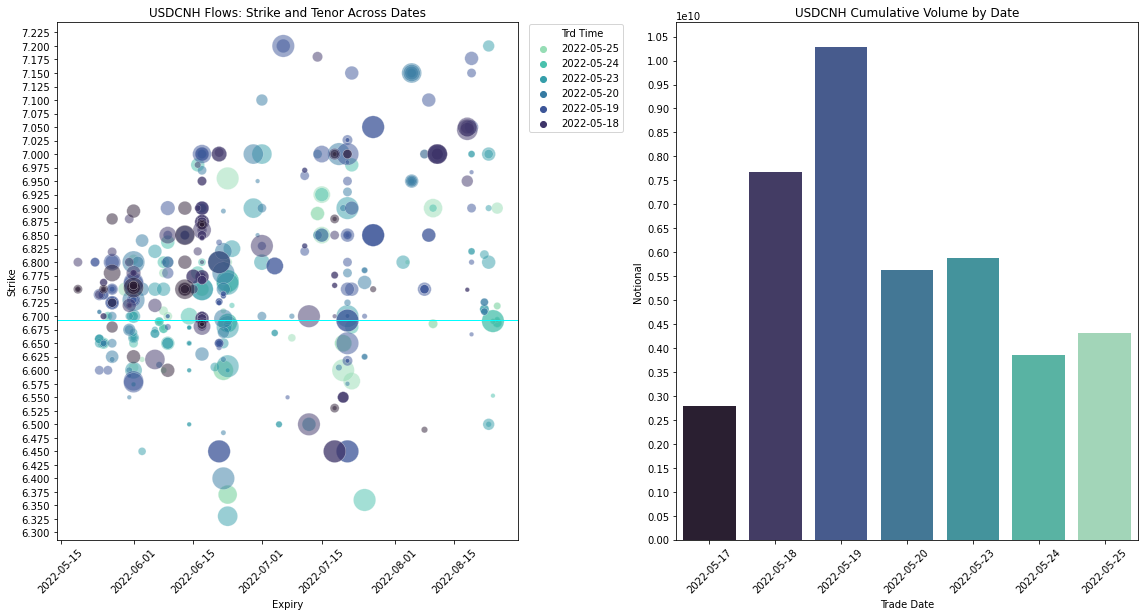

In [57]:
for ccy in ccys2:
    x = datetime.now() + relativedelta(months=3)
    spot=blp.bdp(ccy+" Curncy", 'LAST_PRICE')
    spot_val=(spot["last_price"][0])
    series = val.loc[(val['Expiry']<x) & (val['Notional']>19000000)& (val["CCY_PAIR"]==ccy)]
    stdev = series["Strike"].std()
    mean = series["Strike"].mean()
    series = series.loc[(series["Strike"]-mean)/stdev <=3]
    plt.figure(figsize=(16,16))
    plt.subplot(2,2,1)
    g =sns.scatterplot(data=series, y = 'Strike', x = 'Expiry', size= 'Notional', palette = "mako_r", hue ='Trd Time', alpha=0.5, sizes=(20,500))
    h,l = g.get_legend_handles_labels()
    plt.xticks(rotation=45)
    plt.title("%s Flows: Strike and Tenor Across Dates" % (ccy))
    if ccy=="USDCNY":
        plt.title("USDCNH Flows: Strike and Tenor Across Dates")
    plt.locator_params(axis="y", nbins=40)
    plt.legend(h[0:7],l[0:7],bbox_to_anchor=(1.02, 1), loc=0, borderaxespad=0.2)
    plt.axhspan(spot_val-.00001*spot_val, spot_val+.00001*spot_val, color = "cyan")
    flow = series.groupby(['Trd Time']).sum()["Notional"]
    flow=pd.DataFrame({"Notional": flow})
    flow["Trade Date"]=flow.index
    plt.subplot(2,2,2)
    plt.xticks(rotation=45)
    plt.locator_params(axis="y", nbins=40)
    plt.title("%s Cumulative Volume by Date" %(ccy))
    if ccy=="USDCNY":
        plt.title("USDCNH Cumulative Volume by Date")
    z = sns.barplot(x="Trade Date", y="Notional", data=flow, palette = "mako")  
   
    plt.tight_layout()
    plt.show()